In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_dir = '../input'

In [10]:
visa = pd.read_csv(f'{data_dir}/VisaPremier.txt', sep='\t')

## Exploration des données:

Il existe des variables qui représentent la même information sous deux formes (chaîne de caractères / entiers)

- cartevp / cartevpr
- sexe / sexer

Les types de variables sont les suivants:
- Categorielles:
    - matricul: identifiant (inutile pour l'analyse et le classement)
    
    - cartevp/cartevpr: possession de la carte Visa Premier (binaire). variable a predire
    - codeqlt: code de qualite du client evalue par la banque (A - E)
    - csp: categorie socio-professionnelle (8 valeurs)
    - departem: departement de residence
    - sexe/sexer: le sexe du client (binaire)
    - sitfamil: situation familiale (6 valeurs)
    
- Numeriques:
    - age: l'age du client (annees)
    - agemvt: age du dernier mouvement (jours)
    - anciente: anciennete de la relation (mois)
    - aveparfi: total des avoirs epargne financiere (francs)
    - aveparmo: total des avoirs epargne monetaire (francs)
    - avtscpte: total des avoirs sur tous les comptes (francs) --> `avtscpte ?= aveparfi + aveparmo + ...`
    - endette: taux d'endettement (pourcentage)
    - engagemc: Total des engagements court terme (francs)
    - engageml: Engagement long terme
    - engagemm: Total des engagements moyen terme
    - engagemt: Total des engagements (francs) --> `engagemt = engagemc + engagemm + engageml`
    - moycred3: Moyenne des mouvements nets créditeurs des 3 mois (milliers de francs)
    - moycredi: Moyenne des mouvements créditeurs (milliers de francs)
    - moysold3: Moyenne des soldes moyens sur 3 mois
    - mtbon: Montant des produits bons et certificats (francs)
    - mteparlo: Montant des produits d’épargne logement (francs)
    - mteparlt: Montant des produits d’épargne long terme (francs)
    - mteparmo: Montant des produits d’épargne monétaire (francs)
    - mteparte: Nombre de produits épargne à terme
    - mtfactur: Montant facturé dans l’année
    - mtlivret: Montant des comptes sur livret (francs)
    - mtrejet: montant total des rejets (francs)
    - mtvie: Montant des produits contrats vie (francs)
    - nbbon: Nombre de produits bons et certificats
    - nbcb: Nombre total de cartes
    - nbcptar:  Nombre de cartes point argent
    - nbcptvue: Nombre de comptes à vue
    - nbeparlo: Nombre de produits d’épargne logement
    - nbeparlt:  Nombre de produits d’épargne long terme
    - nbeparmo: Nombre de produits épargne monétaire
    - nbeparte: Montant des produits épargne à terme
    - nbimpaye: nombre d'impayés en cours
    - nbjdebit: Nombre de jours de débit
    - nblivret: Nombre de comptes sur livret
    - nbop: Nombre d’opérations à M-1
    - nbopguic: nombre d'opérations par gichets dans le mois
    - nbpaiecb: Nombre de paiements par carte bancaire à M-1
    - nbvie: Nombre de produits contrats vie
    - ptvente: point de vente (nombre de points de vente?)

Les valeurs manquantes qui existent dans les variables sont representees par des '.' (ou F.)

In [11]:
visa.columns.sort_values()

Index(['age', 'agemvt', 'anciente', 'aveparfi', 'aveparmo', 'avtscpte',
       'cartevp', 'cartevpr', 'codeqlt', 'csp', 'departem', 'endette',
       'engagemc', 'engageml', 'engagemm', 'engagemt', 'matricul', 'moycred3',
       'moycredi', 'moysold3', 'mtbon', 'mteparlo', 'mteparlt', 'mteparmo',
       'mteparte', 'mtfactur', 'mtlivret', 'mtrejet', 'mtvie', 'nbbon', 'nbcb',
       'nbcbptar', 'nbcptvue', 'nbeparlo', 'nbeparlt', 'nbeparmo', 'nbeparte',
       'nbimpaye', 'nbjdebit', 'nblivret', 'nbop', 'nbopguic', 'nbpaiecb',
       'nbvie', 'ptvente', 'sexe', 'sexer', 'sitfamil'],
      dtype='object')

In [76]:
quali_vars = ['cartevp', 'codeqlt', 'csp', 'departem', 'sexe', 'sitfamil'] # 'cartevpr', 'sexer' 
quanti_vars = ['age', 'agemvt', 'anciente', 'aveparfi', 'aveparmo', 'avtscpte',
               'endette', 'engagemc', 'engageml', 'engagemm', 'engagemt',
               'moycred3', 'moycredi', 'moysold3', 'mtbon', 'mteparlo', 'mteparlt',
               'mteparmo', 'mteparte', 'mtfactur', 'mtlivret', 'mtrejet', 'mtvie',
               'nbbon', 'nbcb', 'nbcbptar', 'nbcptvue', 'nbeparlo', 'nbeparlt',
               'nbeparmo', 'nbeparte', 'nbimpaye', 'nbjdebit', 'nblivret',
               'nbop', 'nbopguic', 'nbpaiecb', 'nbvie', 'ptvente']

In [55]:
# visa[['aveparfi', 'aveparmo']].sum(axis=1).head(), visa.avtscpte.head()
# (visa[['engagemc', 'engagemm', 'engageml']].sum(axis=1).head() != visa.engagemt.head()).sum()

0

In [32]:
visa.shape

(1073, 48)

### Analyse des valeurs manquantes

In [7]:
na_count = visa.isnull().sum()
na_count[na_count != 0]

Series([], dtype: int64)

In [8]:
visa.matricul.unique().shape

(1073,)

In [51]:
dots = ((visa == '.') | (visa == 'F.'))
dot_count = dots.sum()
dot_count[dot_count != 0] / dot_count.shape[0]

departem    0.145833
sitfamil    0.666667
codeqlt     2.770833
agemvt      0.125000
nbpaiecb    5.791667
dtype: float64

In [52]:
dots.sum(axis=1).value_counts()

0    722
1    247
2    103
3      1
dtype: int64

### Analyse univariée

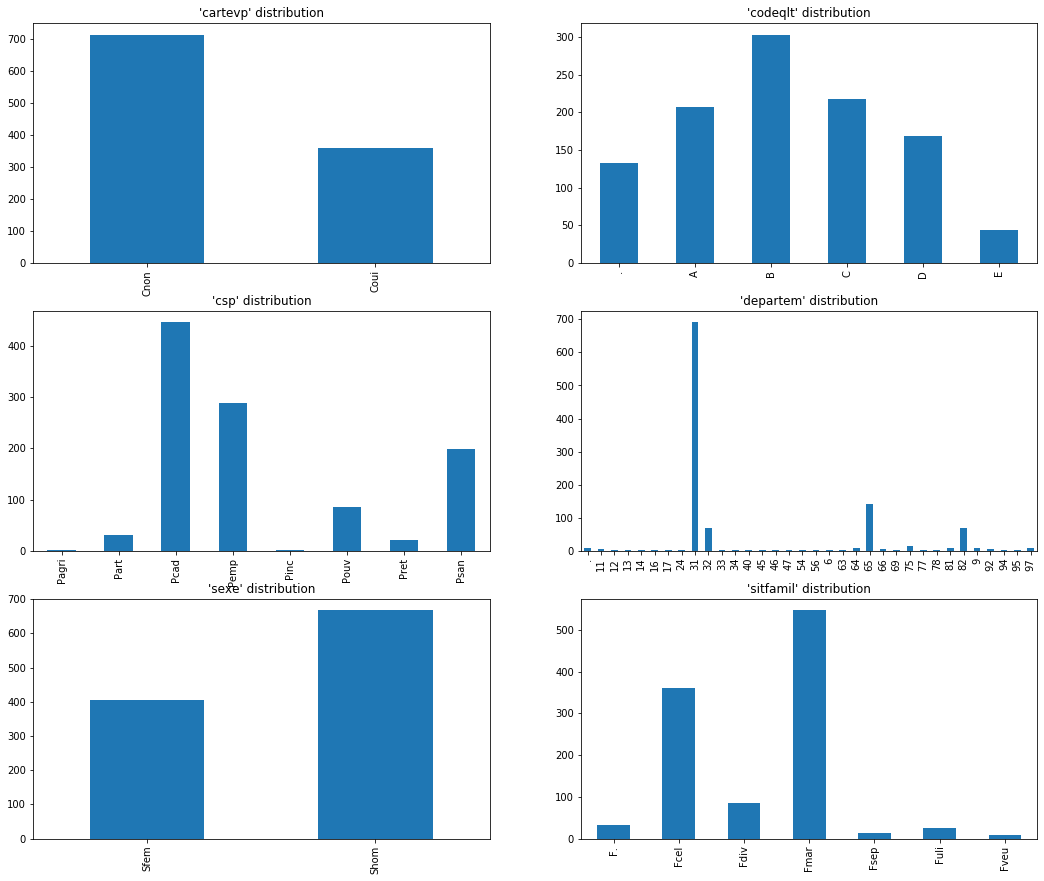

In [79]:
visa_quali = visa[quali_vars]

nrow, ncol = 3,2
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(visa_quali.shape[1]):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = quali_vars[i]
    
    visa_quali[var_name].value_counts().sort_index().plot.bar(ax=ax)
    ax.set_title(f'{var_name!r} distribution')

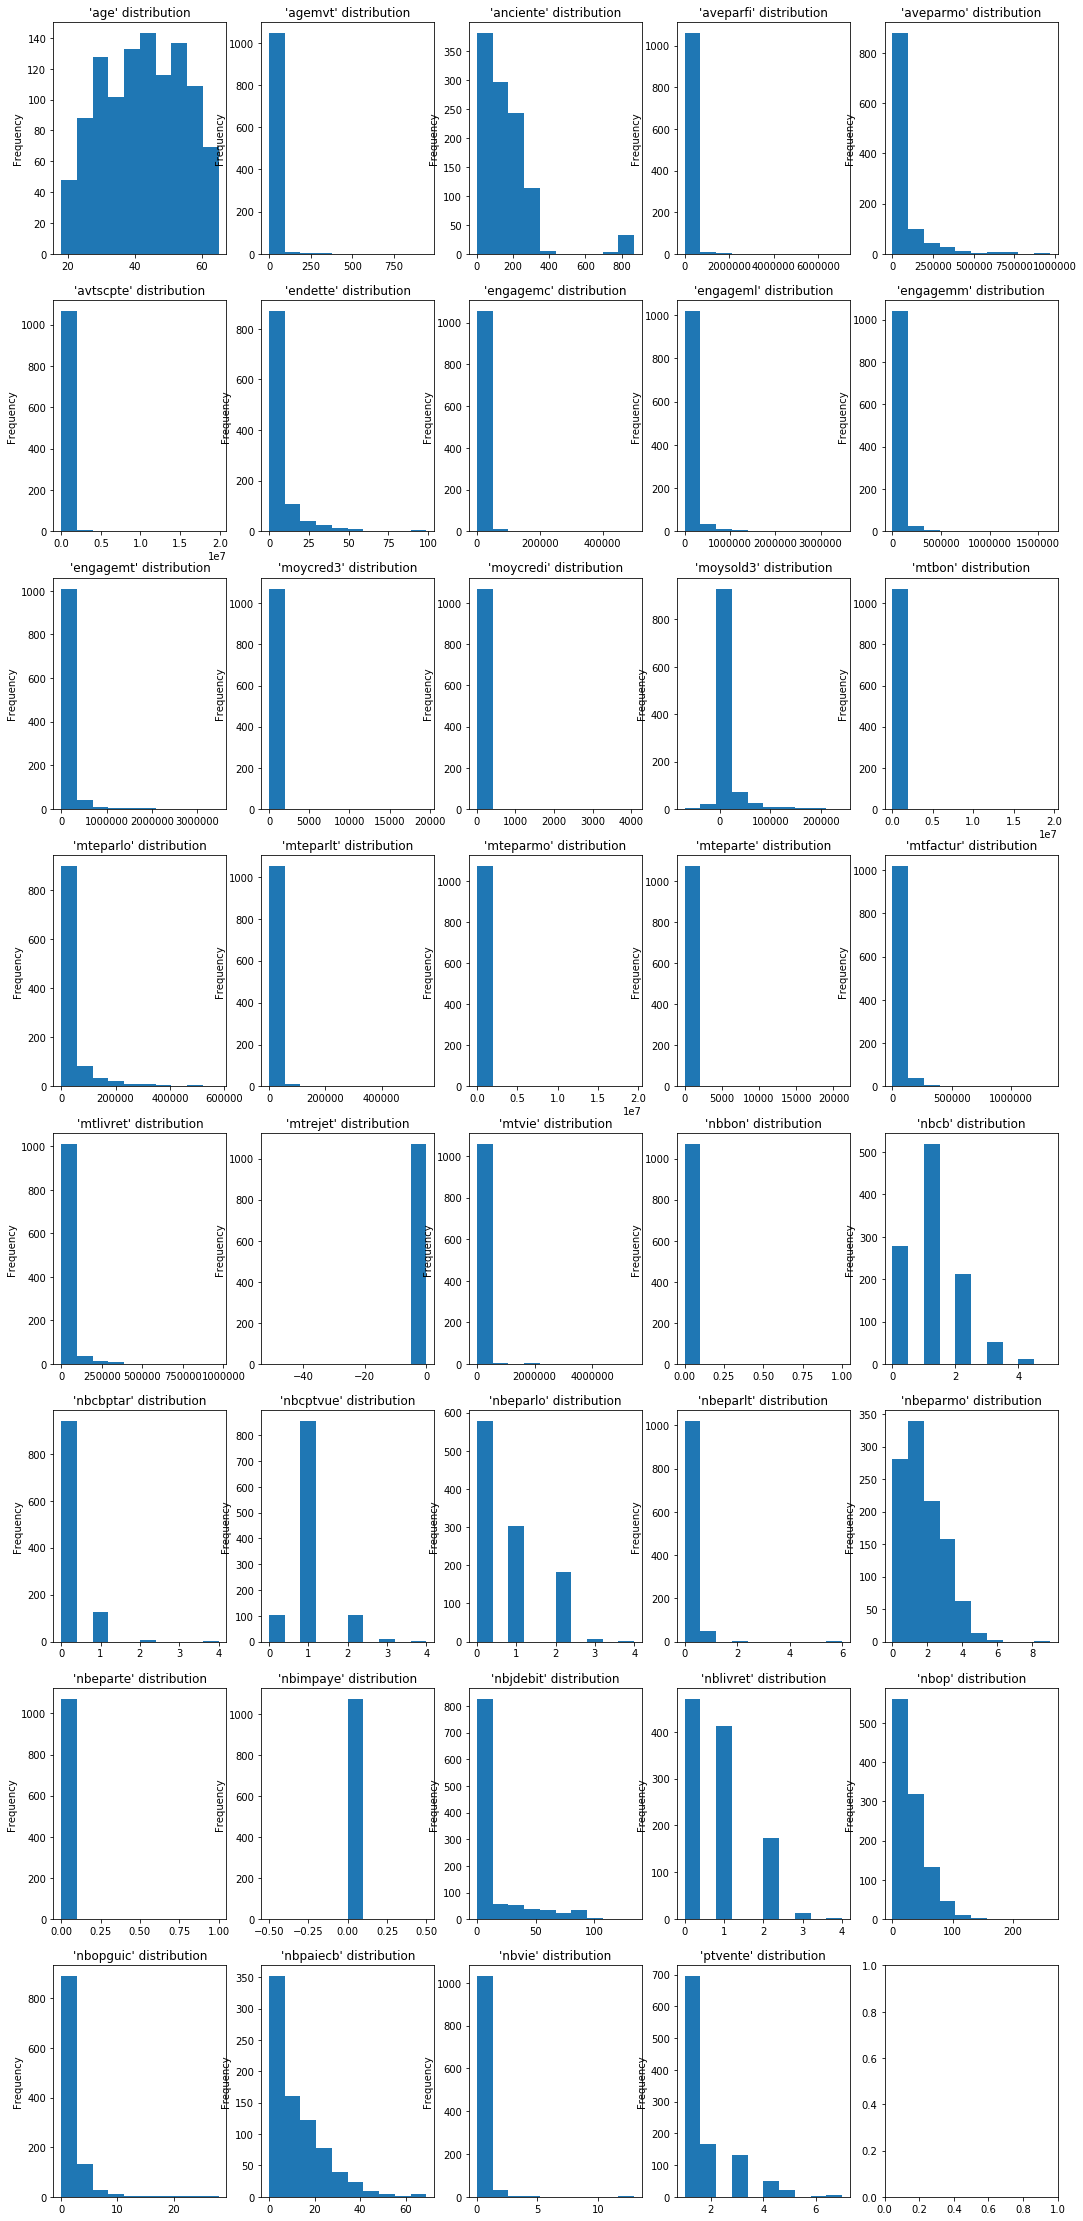

In [87]:
visa_quanti = visa[quanti_vars]
nvars = visa_quanti.shape[1]
ncol = 5
nrow  = nvars // ncol + (1 if nvars%ncol != 0 else 0)
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(nvars):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = quanti_vars[i]
    
    s = visa_quanti[var_name]
    s = s[s != '.'].astype(int) # elimination des valeurs manquantes et transformation en entier
    s.plot.hist(ax=ax)
    ax.set_title(f'{var_name!r} distribution')

In [72]:
visa_quanti.agemvt.astype(int)#.plot.hist()

0       11
1       11
2       14
3       11
4       11
        ..
1068     0
1069     0
1070    13
1071    13
1072     0
Name: agemvt, Length: 1067, dtype: int64

### Analyse multivariée

## Classification supervisée